Implementation of binary classification algorithm on a cancer data set for differenctiating between benign and malignant tumors.**bold text** **bold text**

In [52]:
# Required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('cancer_data.csv')

# Data preprocessing
df.drop(['Unnamed: 32', 'id'], inplace=True, axis=1)
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})
print(df.head())


   diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0          1        17.99         10.38          122.80     1001.0   
1          1        20.57         17.77          132.90     1326.0   
2          1        19.69         21.25          130.00     1203.0   
3          1        11.42         20.38           77.58      386.1   
4          1        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   symmetry_mean  ...  radius_worst  texture_worst  perimeter_worst  \
0         0.2419  ...         25.38          

## Data Splitting

We split the data into training (70%) and testing (30%) datasets.

In [55]:
# Extract input and output data
data = df.to_numpy()
data_in = data[:, 1:]  # input
data_out = data[:, 0]  # output (m,) vector
data_out = np.reshape(data_out, (-1, 1))

print(f"input dim: {data_in.shape}")
print(f"output dim: {data_out.shape}")

# Split data into training and test sets
ratio = 0.7  # percentage of training dataset
len_tr = int(ratio * len(data_in))

tr_data_in = data_in[:len_tr]
tr_data_out = data_out[:len_tr]
test_data_in = data_in[len_tr:]
test_data_out = data_out[len_tr:]

print(f"number of train data: {tr_data_in.shape}")
print(f"number of test data: {test_data_in.shape}")


input dim: (569, 30)
output dim: (569, 1)
number of train data: (398, 30)
number of test data: (171, 30)


## Feature Transformation

Implement polynomial features and min-max normalization.


In [56]:
# Implement polynomial features
def polynomial_features(X, degree):
    from itertools import combinations_with_replacement
    num_samples, num_features = X.shape
    features = [np.ones(num_samples)]  # Start with the bias term

    for degree in range(1, degree + 1):
        for comb in combinations_with_replacement(range(num_features), degree):
            features.append(np.prod(X[:, comb], axis=1))

    return np.column_stack(features)

# Implement min-max normalization with zero division handling
def minmax_normalize(X):
    minimum = np.min(X, axis=0)
    maximum = np.max(X, axis=0)
    range_values = maximum - minimum
    range_values[range_values == 0] = 1  # Avoid division by zero
    newX = (X - minimum) / range_values
    return newX


## Model Functions

Implement necessary functions for logistic regression: sigmoid, loss function, gradient descent, and prediction.


In [57]:
# Implement sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Implement loss function
def loss_function(y, y_pred):
    epsilon = 1e-5  # To prevent log(0)
    loss = -np.mean(y * np.log(y_pred + epsilon) + (1 - y) * np.log(1 - y_pred + epsilon))
    return loss

# Implement gradient descent
def gradient_descent(X, y, lr, epochs):
    m, n = X.shape
    X = np.hstack((np.ones((m, 1)), X))  # Add bias term
    theta = np.zeros((n + 1, 1))
    losses = []

    for i in range(epochs):
        z = np.dot(X, theta)
        y_pred = sigmoid(z)
        gradient = np.dot(X.T, (y_pred - y)) / m
        theta -= lr * gradient
        losses.append(loss_function(y, y_pred))

    return theta, losses

# Implement logistic regression prediction
def predict(X, theta):
    X = np.hstack((np.ones((X.shape[0], 1)), X))
    return sigmoid(np.dot(X, theta))


## Train the Model

Normalize data, add polynomial features, and train the model using gradient descent.


In [1]:
# Train the model
degree = 2
tr_data_in = polynomial_features(minmax_normalize(tr_data_in), degree)
test_data_in = polynomial_features(minmax_normalize(test_data_in), degree)

lr = 0.01
epochs = 1000
theta, losses = gradient_descent(tr_data_in, tr_data_out, lr, epochs)


NameError: name 'polynomial_features' is not defined

## Model Evaluation

Evaluate the model using confusion matrix and calculate performance metrics (precision, recall, F1 score, accuracy).


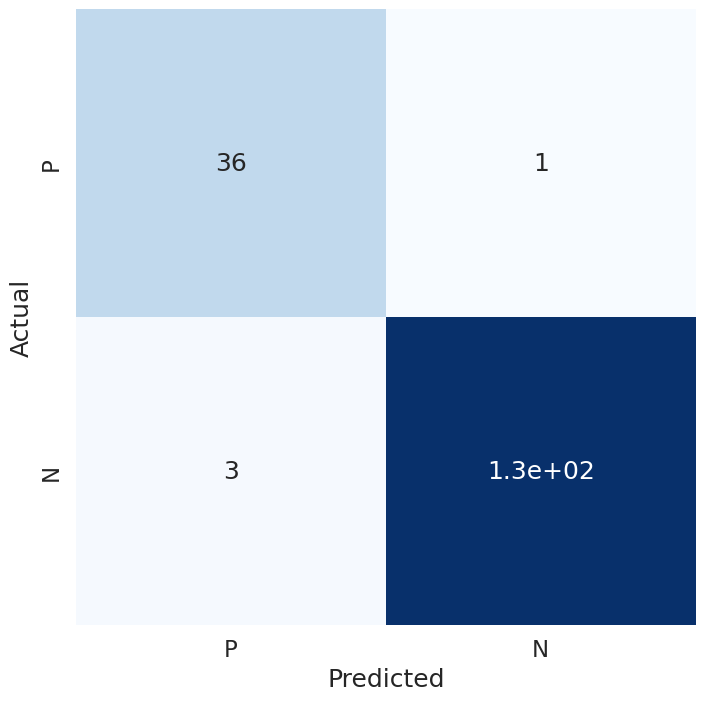

Precision: 0.972972972972973, Recall: 0.9230769230769231, F1 Score: 0.9473684210526315, Accuracy: 0.9766081871345029


In [60]:
# Model evaluation
def plot_conf_mat(conf_mat):
    class_label = ["P", "N"]
    plt.subplots(figsize=(8, 8))
    sns.set(font_scale=1.5)
    sns.heatmap(conf_mat, annot=True, cbar=False, xticklabels=class_label, yticklabels=class_label, cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

def confusion_matrix(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return np.array([[tp, fp], [fn, tn]])

def calculate_metrics(conf_mat):
    tp, fp, fn, tn = conf_mat.ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * precision * recall / (precision + recall)
    return precision, recall, f1_score

def calculate_accuracy(X, y, theta):
    y_pred = predict(X, theta)
    y_pred = y_pred >= 0.5
    accuracy = np.mean(y_pred == y)
    return accuracy

def evaluate_model(X, y, theta):
    y_pred = predict(X, theta)
    y_pred = y_pred >= 0.5
    conf_mat = confusion_matrix(y, y_pred)
    plot_conf_mat(conf_mat)
    precision, recall, f1_score = calculate_metrics(conf_mat)
    accuracy = calculate_accuracy(test_data_in, test_data_out, theta)
    print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1_score}, Accuracy: {accuracy}")

evaluate_model(test_data_in, test_data_out, theta)


## Learning Curve

Plot the learning curve to visualize the loss over epochs.


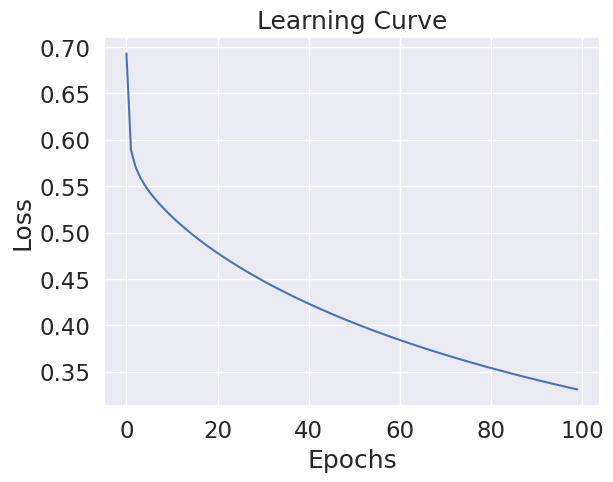

In [61]:
plt.plot(losses)
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
